In [1]:
import os
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from args import BASE_PATH
from continuous_prediction.algo.arima import rolling_forecast, train_model
from continuous_prediction.algo.common.data_processor import create_split, create_df
from continuous_prediction.algo.common.eval_metrics import mape
from continuous_prediction.algo.common.parameter_tuning import adfuler_test, shift_series
from matplotlib import pyplot
from utils.file_util import create_folder_if_not_exist

import warnings
warnings.filterwarnings("ignore")

In [2]:
data_file_path = os.path.join(BASE_PATH, "data/manufacturing.csv")

In [3]:
# load data
df = pd.read_csv(data_file_path, delimiter=',', index_col=0)
series = df['Data']

print(f'length of series: {len(series)}')

length of series: 92


#### Parameter extraction

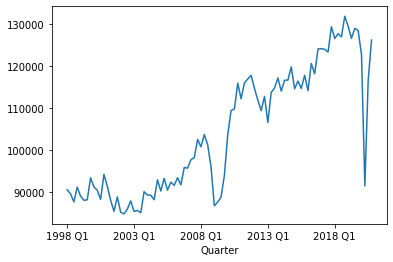

ADF Statistic: -0.6553941590063763
p-value: 0.8579677199834425
Critical Values:
	1%: -3.5097356063504983
	5%: -2.8961947486260944
	10%: -2.5852576124567475


In [4]:
# plot series
series.plot()
pyplot.show()

adfuler_test(series)
# if p=value# if p-value>0.05 -> Accept NULL hypothesis -> not stationary -> shift series to be stationary

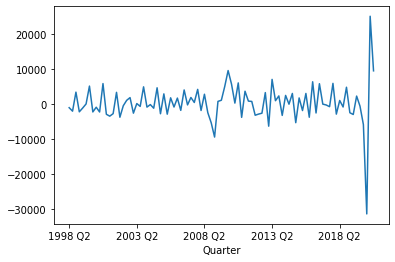

ADF Statistic: -5.161755727204862
p-value: 1.0518340275812103e-05
Critical Values:
	1%: -3.5097356063504983
	5%: -2.8961947486260944
	10%: -2.5852576124567475


In [5]:
series_new = shift_series(series, 1)
series_new = series_new.dropna()
series_new.plot()
pyplot.show()

adfuler_test(series_new)
# d = 1

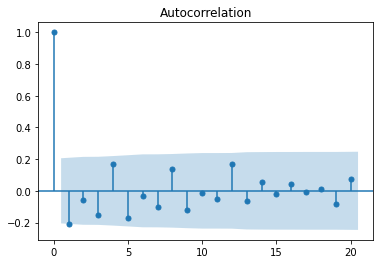

In [6]:
# Auto Correlation Function (ACF) to determine optimal number of MA terms (q)
x = plot_acf(series_new)
# q = 2-5

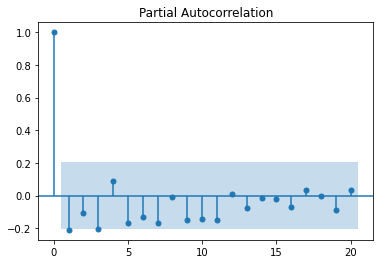

In [7]:
# Partial Auto Correlation Function (PACF) to determine the optimal number of terms to use in the AR model (p)
x = plot_pacf(series_new)
# p = 3 - 5

#### Predict 1 future value

In [8]:
data_args = {
    'test_split': 0.3,
    'future_n': 1,
}

arima_args = {
    'p': 3,
    'd': 1,
    'q': 2,
}

result_file_path = os.path.join(BASE_PATH, "results/ARIMA/manufacturing-" + str(data_args['future_n']) + '.csv')
create_folder_if_not_exist(result_file_path, is_file_path=True)

In [9]:
# split data
train, test = create_split(series, args=data_args)

print(f'train data: {len(train)}')
print(f'test data: {len(test)}')


train data: 65
test data: 27


Test MSE: 76400350.992902
Test RMSE: 8740.729431
Test MAPE: 0.045043
['2021 Q1']
         Original     Prediction
Time                            
2014 Q2  116607.7  114243.082252
2014 Q3  116669.7  116621.918872
2014 Q4  119798.5  116392.059038
2015 Q1  114578.3  119768.505733
2015 Q2  116425.5  114879.296734


<AxesSubplot:xlabel='Time'>

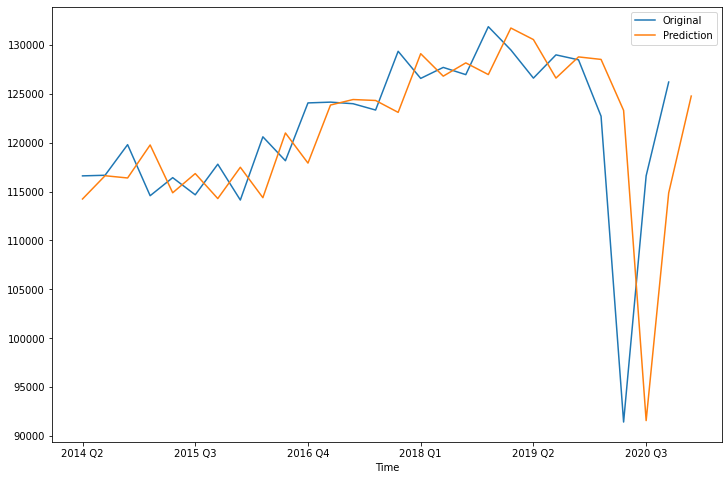

In [10]:
# Rolling forecast for model validation
predictions = rolling_forecast(train, test, data_args, arima_args)

# Evaluation
error = mean_squared_error(test, predictions)
print('Test MSE: %.6f' % error)
rmse1 = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.6f' % rmse1)
mape_val = mape(test, predictions)
print('Test MAPE: %.6f' %mape_val)

# future predictions
model_fit = train_model(series, arima_args)
output = model_fit.predict(start=len(series),end=len(series)+data_args['future_n']-1,dynamic=True, typ='levels')
predictions.extend(output)

result_df = create_df(test.index.values.tolist(), test.values.tolist(), predictions)
result_df.to_csv(result_file_path, sep=',', encoding='utf-8', index=True)

print(result_df.head())

result_df[['Original', 'Prediction']].plot(figsize=(12,8))


#### Predict 4 future values

In [11]:
data_args = {
    'test_split': 0.3,
    'future_n': 4,
}

arima_args = {
    'p': 4,
    'd': 1,
    'q': 3,
}

result_file_path = os.path.join(BASE_PATH, "results/ARIMA/manufacturing-" + str(data_args['future_n']) + '.csv')
create_folder_if_not_exist(result_file_path, is_file_path=True)

In [12]:
# split data
train, test = create_split(series, args=data_args)

print(f'train data: {len(train)}')
print(f'test data: {len(test)}')

train data: 64
test data: 28


Test MSE: 62391783.133858
Test RMSE: 7898.846950
Test MAPE: 0.037021
['2021 Q1', '2021 Q2', '2021 Q3', '2021 Q4']
         Original     Prediction
Time                            
2014 Q1  114039.2  117194.370464
2014 Q2  116607.7  117432.643230
2014 Q3  116669.7  117454.846140
2014 Q4  119798.5  117293.292232
2015 Q1  114578.3  119019.892119


<AxesSubplot:xlabel='Time'>

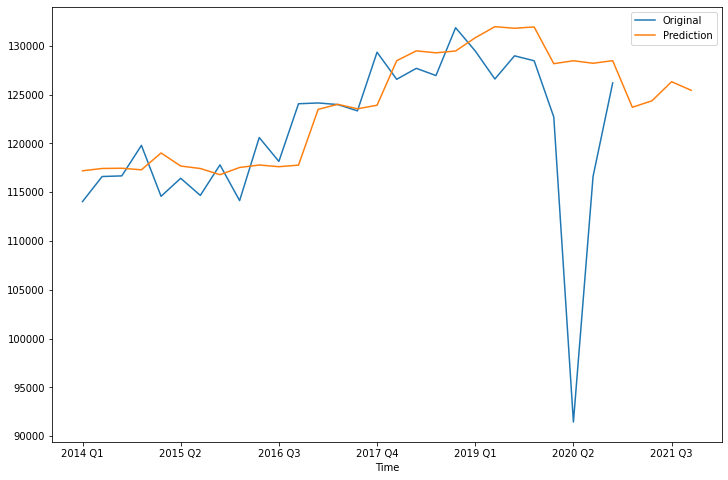

In [13]:
# Rolling forecast for model validation
predictions = rolling_forecast(train, test, data_args, arima_args)

# Evaluation
error = mean_squared_error(test, predictions)
print('Test MSE: %.6f' % error)
rmse1 = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.6f' % rmse1)
mape_val = mape(test, predictions)
print('Test MAPE: %.6f' %mape_val)

# future predictions
model_fit = train_model(series, arima_args)
output = model_fit.predict(start=len(series),end=len(series)+data_args['future_n']-1,dynamic=True, typ='levels')
predictions.extend(output)

result_df = create_df(test.index.values.tolist(), test.values.tolist(), predictions)
result_df.to_csv(result_file_path, sep=',', encoding='utf-8', index=True)

print(result_df.head())

result_df[['Original', 'Prediction']].plot(figsize=(12,8))






